In [1]:
%cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import os
import src
import amber
from src.reload import reload_from_dir
from src.kinetic_model import KineticModel, modelSpace_to_modelParams
from src.neural_network_builder import KineticNeuralNetworkBuilder, KineticEigenModelBuilder
from src.model_spaces import get_cas9_uniform_ms, get_cas9_finkelstein_ms
from src.data import load_finkelstein_data as get_data

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf

Using TensorFlow backend.


In [3]:
# trainEnv parameters; reduced version
evo_params = dict(
    model_fn = KineticNeuralNetworkBuilder,
)

# manager configs
manager_kwargs={
    'output_op': lambda: tf.keras.layers.Lambda(lambda x: tf.math.log(tf.clip_by_value(x, 10**-5, 10**-1))/np.log(10), name="output_log"),  # change the clip as well
    'n_feats': 25,  # remember to change this!!
    'n_channels': 9,
}

In [4]:
sess = tf.Session()
wd = "outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep4-gRNA1"
kinn1 = reload_from_dir(wd=wd, sess=sess, manager_kwargs=manager_kwargs, model_fn=KineticNeuralNetworkBuilder)

wd = "outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep5-gRNA2"
kinn2 = reload_from_dir(wd=wd, sess=sess, manager_kwargs=manager_kwargs, model_fn=KineticNeuralNetworkBuilder)


In [5]:
# load cnn
wd = "outputs/CNN-wtCas9_cleave_rate_log-0/"
train_hist = pd.read_table(os.path.join(wd, "train_history.csv"), sep=",", header=None)
best_trial_id = train_hist.sort_values(2, ascending=False).head(1)[0]
dcnn1 = tf.keras.models.load_model(os.path.join(wd, "weights", "trial_%i"%best_trial_id, "bestmodel.h5"))

wd = "outputs/CNN-wtCas9_cleave_rate_log-1/"
train_hist = pd.read_table(os.path.join(wd, "train_history.csv"), sep=",", header=None)
best_trial_id = train_hist.sort_values(2, ascending=False).head(1)[0]
dcnn2 = tf.keras.models.load_model(os.path.join(wd, "weights", "trial_%i"%best_trial_id, "bestmodel.h5"))

## Fig. 4AB

Compare the predictions of best KINN vs CNN vs observed values

In [6]:
(x1, y1), _ = get_data(target="wtCas9_cleave_rate_log", make_switch=False, logbase=10, include_ref=False)
(x2, y2), _ = get_data(target="wtCas9_cleave_rate_log", make_switch=True, logbase=10, include_ref=False)

In [7]:
# use the held-out data/model combinations
y1_kinn_p = kinn2.predict(x1)
y1_cnn_p = dcnn2.predict(x1)

y2_kinn_p = kinn1.predict(x2)
y2_cnn_p = dcnn1.predict(x2)

In [8]:
plot_df = pd.DataFrame({
    "obs": np.concatenate([y1,y2]), 
    "kinn_pred": np.concatenate([y1_kinn_p[:,0], y2_kinn_p[:,0]]), 
    "cnn_pred": np.concatenate([y1_cnn_p[:,0], y2_cnn_p[:,0]]), 
})
plot_df['pred_diff'] = plot_df['kinn_pred'] - plot_df['cnn_pred']
plot_df['obs_bin'] = pd.cut(plot_df['obs'], np.arange(-6,1,1))

In [9]:
plot_df.head()

,obs,kinn_pred,cnn_pred,pred_diff,obs_bin
0,-1.032424,-1.085633,-1.063932,-0.021701,"(-2, -1]"
1,-1.153478,-1.132275,-1.038296,-0.093980,"(-2, -1]"
2,-0.930150,-1.311494,-1.094851,-0.216644,"(-1, 0]"
3,-0.717589,-1.122313,-1.080688,-0.041626,"(-1, 0]"
4,-1.103914,-1.630765,-1.023064,-0.607701,"(-2, -1]"


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


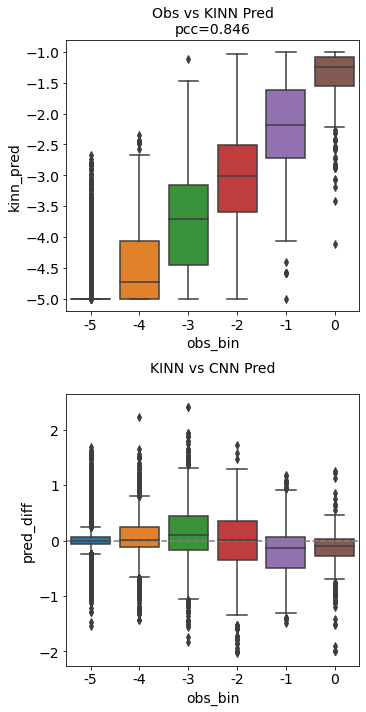

In [10]:
%matplotlib inline
fig, axs = plt.subplots(2,1, figsize=(5,10))

ax = sns.boxplot(x='obs_bin', y='kinn_pred', data=plot_df, ax=axs[0])
#ax = sns.kdeplot(x='obs_bin', y='kinn_pred', data=plot_df, ax=axs[0], fill=True, alpha=0.6, cut=2,)
#ax.set_xlim(-5.5, -0)
#ax.set_ylim(-5.5, -0)
#ax.axline((0,0),(1,1), color='grey', ls='--')
ax.set_title("Obs vs KINN Pred\npcc=%.3f" % ss.pearsonr(plot_df['obs'], plot_df['kinn_pred'])[0])
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
ax.set_xticklabels(ax.get_xticks()-5)



ax = sns.boxplot(x='obs_bin', y='pred_diff', data=plot_df, ax=axs[1])
ax.axline((0,0), (1,0), color='grey', ls='--')
ax.set_title("KINN vs CNN Pred\n")
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
ax.set_xticklabels(ax.get_xticks()-5)

fig.tight_layout()

## Fig. 4C

comparison of mutagensis effects

In [11]:
def in_sillico_mutagen(x, model, verbose=False):
    score = np.zeros(x.shape)
    ref = model.predict(x).flatten()
    ref = np.clip(ref, -5, -1)
    for i in range(x.shape[-2]):
        for j in range(x.shape[-1]):
            x_m = x.copy()
            x_m[:,i] = 0
            x_m[:,i,j] = 1
            score[:,i,j] = ref - np.clip(model.predict(x_m).flatten(), -5, -1)
    return score.squeeze()
        

In [12]:
# get single nucleotide effects
matched = np.zeros((1,25,9))
mut_k1 = in_sillico_mutagen(matched, kinn1)[3:23]
mut_k2 = in_sillico_mutagen(matched, kinn2)[3:23]
mut_k = (mut_k1 + mut_k2)/2

mut_c1 = in_sillico_mutagen(matched, dcnn1)[3:23]
mut_c2 = in_sillico_mutagen(matched, dcnn2)[3:23]
mut_c = (mut_c1 + mut_c2)/2

Text(0.5, 1.0, 'Mutation effects comparison\npcc=0.932')

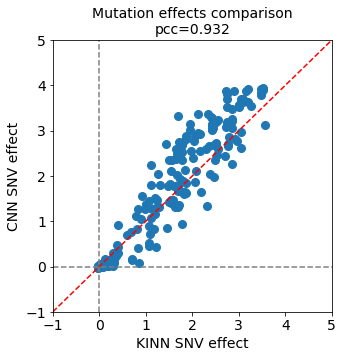

In [13]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.set_xlim(-1,5)
ax.set_ylim(-1,5)
ax.scatter(mut_k.reshape(-1), mut_c.reshape(-1))
ax.plot([0,1], [0,1], transform=ax.transAxes, ls='--', c="red")
ax.set_xlabel("KINN SNV effect")
ax.set_ylabel("CNN SNV effect")
ax.axvline(0, ls="--", c="grey")
ax.axhline(0, ls="--", c="grey")
ax.set_title("Mutation effects comparison\npcc=%.3f" % ss.pearsonr(mut_k.reshape(-1), mut_c.reshape(-1))[0])

## Fig. 4EF

Penalty of Off-targeting along the gRNA-DNA complex

In [14]:
penlty_df = pd.DataFrame(dict(
    idx = (np.arange(0,mut_k.shape[0])+0.5).tolist() * 3,
    pnt = np.concatenate([
        mut_k.T[0:4, :].mean(axis=0), 
        mut_k.T[4:7, :].mean(axis=0),
        mut_k.T[8, :]]),
    typ = ['substitution']*mut_k.shape[0] + ['insertion']*mut_k.shape[0] + ['deletion']*mut_k.shape[0]
))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


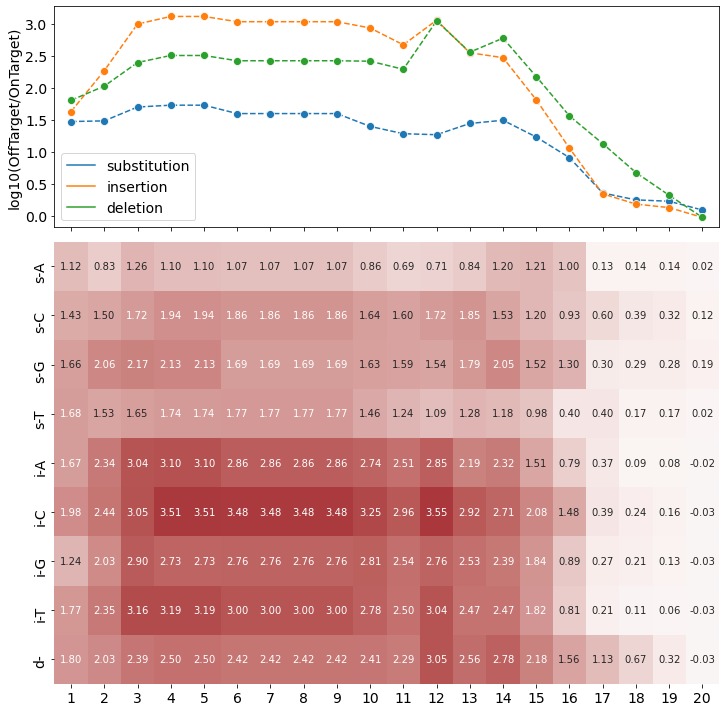

In [15]:
# thus, do not include the PAM
fig, axs = plt.subplots(2, 1, figsize=(10,10), gridspec_kw={'height_ratios': [1, 2]}, sharex=True)

sns.lineplot(x='idx', y='pnt', hue='typ', data=penlty_df, ax=axs[0], marker='o', ls='--', linewidth=1.5)
#axs.plot(np.arange(0,mut_k.shape[0]), mut_k.T.mean(axis=0), color='k', linewidth=3)
#axs[0].legend(loc='upper left', bbox_to_anchor=(1,1.05))
axs[0].legend(loc='lower left')
axs[0].set_ylabel('log10(OffTarget/OnTarget)')

#fig, axs = plt.subplots(1, 1, figsize=(9,6))
sns.heatmap(mut_k.T, annot=True, ax=axs[1], center=0, cbar=False, fmt=".2f", 
            cmap=sns.color_palette("vlag", as_cmap=True),
            yticklabels=['s-A','s-C','s-G','s-T','i-A','i-C','i-G','i-T','d-'],
            #xticklabels=['G', 'G', 'N'] + np.arange(1,21).tolist()
            xticklabels=np.arange(1,21).tolist()
)
#axs.set_title('SNV in Matched: KINN')
fig.tight_layout()

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Sep 08 2022

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.22.0

tensorflow: 1.15.0
scipy     : 1.7.3
seaborn   : 0.11.1
numpy     : 1.21.6
amber     : 0.1.2-pmbga
pandas    : 1.3.5
src       : 0.0.1
matplotlib: 3.4.3

Watermark: 2.3.1

